In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import glob
import spacy
import json
import en_core_web_sm

from tqdm.notebook import tqdm
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler
from spacy.language import Language
nlp = spacy.load('en_core_web_sm', exclude='ner')

In [7]:
!spacy info


============================== Info about spaCy ==============================

spaCy version    3.0.5                         
Location         c:\users\berka\appdata\local\programs\python\python37\lib\site-packages\spacy
Platform         Windows-10-10.0.19041-SP0     
Python version   3.7.9                         
Pipelines        en_core_web_sm (3.0.0)        



2021-06-05 11:52:18.045204: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-05 11:52:18.045321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
with open('ner_patterns.json') as f:
    data = json.load(f)

In [9]:
ruler = EntityRuler(nlp, overwrite_ents=True)
patterns = data
ruler.add_patterns(patterns)

ruler.to_disk('Entity_ruler')

@Language.component('ent_ruler')
def ent_ruler(doc):
    ruler(doc)
    return doc

if 'ent_ruler' in nlp.pipe_names:
    nlp.remove_pipe('ent_ruler')
    
nlp.add_pipe('ent_ruler')
nlp.to_disk('spacy_model')

In [10]:
genres = pd.read_csv('imdb_with_wiki.csv')['genre']

dataset = pd.unique(genres.dropna())
temp = []
    
for i in range(len(dataset)):
    temp += dataset[i].lower().split(", ")

genres = list(set(temp))
genres.append('science fiction')

In [11]:
matcher = Matcher(nlp.vocab)
pattern = [
    [{"LEMMA": {"IN": ["write", "direct", "director", "writer"]}} ],
    ]

matcher.add("matching", pattern) 

In [12]:
def get_edges(content):
    content = content.replace('===', '==').replace('====', '==')
    content = content.split('==')
    
    cast = []
    genre = []
    director = []
    writer = []
    plot = []
    drt_wrt = []
    producer = []
    award = []
    
    dict1 = {}
    for i in range(1,len(content),2):
        try:
            key = content[i][1:-1]
            dict1[key.lower()] = content[i+1]
        except:
            None
      
    #Cast
    try:
        casting = dict1['cast'].split('\n')
        casting = [i for i in casting if i != '']
        for i in casting:
            cast.append((i.split(' as ')[0], 'cast')) 
    except:
        None
        
    #Plot
    try:
        temp = dict1['plot'].replace('\n', '')
        plot.append((temp, 'plot'))
    except:
        None

    #Production
    try:
        temp = dict1['production'].replace('\n', '')
        producer.append((temp, 'producer'))
    except:
        None

    
    for sent in  nlp(content[0]).sents:
        doc = sent

        matches = matcher(doc)
        edges = []
        ents = []

        for i in range(len(matches)):
            if doc[matches[i][1]:matches[i][2]].text.find('writ') != -1:
                edges.append('writer')
            else:
                edges.append('director')

        for ent in doc.ents:
            if ent.label_ == 'GNR':
                genre.append((ent.text, 'genre'))
            if ent.label_ in ['WRT','DTR']:
                ents.append(ent.text)
                
        for i in range(len(ents)):
            try:
                drt_wrt.append((ents[i], edges[i]))
            except:
                if len(edges) != 0:
                    drt_wrt.append((ents[i], edges[-1]))
                
        if sent.text.find('award') != -1:
            award.append((sent.text, 'award'))

    KG_edges = cast + genre + drt_wrt + plot + producer + award
    return KG_edges


    

In [13]:
def build_graph(directory, KG=nx.DiGraph()):
    Graph = KG
    index = 0
    number_of_films = 0
    flist = glob.glob(str(directory)+'\*')
    
    
    for ix in tqdm(range(len(flist))):
        file = flist[ix]
        with open(file, 'r') as f:
            content = f.read()
            
        title = file[7:-4].lower()
        edges = get_edges(content)
        
        if len(edges) == 0:
            continue
        number_of_films += 1
        
        for edge in edges:
            if edge[1] in ['producer', 'plot', 'award']:
                Graph.add_edge(title, index, relation=edge[1])
                Graph.nodes.data()[index]['content'] = edge[0]
                index += 1
            else:
                Graph.add_edge(title, edge[0], relation=edge[1])
    
    print('number of folders: ', len(flist))
    print('number of movies in the graph: ',number_of_films)
    return Graph

In [14]:
def build_on_graph(graph_url, files_url):
    ex_Graph = nx.read_gexf(graph_url)
    KG = build_graph(files_url, ex_Graph)
    return KG

def build_new_Graph(files_url):
    KG = build_graph(files_url)
    return KG

In [15]:
KG = build_new_Graph('Movies')


number of folders:  9695
number of movies in the graph:  9378


In [16]:
nx.write_edgelist(KG, "Knowledge_Graph_EdgeList")

plt.figure(figsize=(12,12))

pos = nx.spring_layout(KG)
nx.draw(KG, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [ ]:
nx.write_gexf(KG, "Knowledge_diGraph")

In [67]:
nx.write_gpickle(KG,"Knowledge_diGraph.gpickle")

In [22]:
diG = nx.read_gpickle("K1.gpickle")

In [42]:
diG = nx.DiGraph(diG.edges('2 fast 2 furious'))

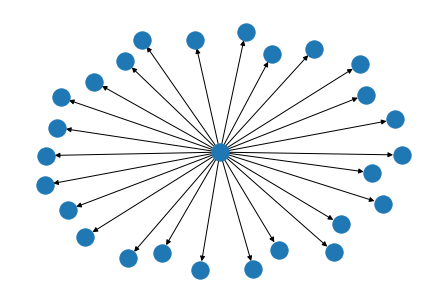

In [45]:
nx.draw(diG)

In [66]:
for i in diG.successors('2 fast 2 furious'):
    print(i)

paul walker
tyrese gibson
eva mendes
cole hauser
chris "ludacris" bridges
devon aoki
james remar
thom barry
edward finlay
mark boone junior
mo gallini
roberto sanchez
mc jin
amaury nolasco
michael ealy
john cenatiempo
eric etebari
action
john singleton
michael brandt
derek haas
gary scott thompson
rob cohen
41
42
43
